In [1]:
# -*- coding: utf-8 -*-
"""
Created on Mon May  8 13:27:29 2023

"""


import os
from typing import Optional

import numpy as np

import gym
from gym import spaces
from gym.error import DependencyNotInstalled


def cmp(a, b):
    return float(a > b) - float(a < b)


# 1 = Ace, 2-10 = Number cards, Jack/Queen/King = 10
deck = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 10, 10, 10]


def draw_card(np_random):
    return int(np_random.choice(deck))


def draw_hand(np_random):
    return [draw_card(np_random), draw_card(np_random)]


def usable_ace(hand):  # Does this hand have a usable ace?
    return 1 in hand and sum(hand) + 10 <= 21

def usable_split(hand):
    return (len(hand) == 2 and hand[0]==hand[1])


def sum_hand(hand):  # Return current hand total
    if usable_ace(hand):
        return sum(hand) + 10
    return sum(hand)


def is_bust(hand):  # Is this hand a bust?
    return sum_hand(hand) > 21


def score(hand):  # What is the score of this hand (0 if bust)
    return 0 if is_bust(hand) else sum_hand(hand)


def is_natural(hand):  # Is this hand a natural blackjack?
    return sorted(hand) == [1, 10]


class BlackjackEnv(gym.Env):
    """
    Blackjack is a card game where the goal is to beat the dealer by obtaining cards
    that sum to closer to 21 (without going over 21) than the dealers cards.

    ### Description
    Card Values:

    - Face cards (Jack, Queen, King) have a point value of 10.
    - Aces can either count as 11 (called a 'usable ace') or 1.
    - Numerical cards (2-9) have a value equal to their number.

    This game is played with an infinite deck (or with replacement).
    The game starts with the dealer having one face up and one face down card,
    while the player has two face up cards.

    The player can request additional cards (hit, action=1) until they decide to stop (stick, action=0)
    or exceed 21 (bust, immediate loss).
    After the player sticks, the dealer reveals their facedown card, and draws
    until their sum is 17 or greater.  If the dealer goes bust, the player wins.
    If neither the player nor the dealer busts, the outcome (win, lose, draw) is
    decided by whose sum is closer to 21.
    ### Action Space
    There are two actions: stick (0), and hit (1).

    ### Observation Space
    The observation consists of a 3-tuple containing: the player's current sum,
    the value of the dealer's one showing card (1-10 where 1 is ace),
    and whether the player holds a usable ace (0 or 1).

    This environment corresponds to the version of the blackjack problem
    described in Example 5.1 in Reinforcement Learning: An Introduction
    by Sutton and Barto (http://incompleteideas.net/book/the-book-2nd.html).

    ### Rewards
    - win game: +1
    - lose game: -1
    - draw game: 0
    - win game with natural blackjack:

        +1.5 (if <a href="#nat">natural</a> is True)

        +1 (if <a href="#nat">natural</a> is False)

    ### Arguments

    ```
    gym.make('Blackjack-v1', natural=False, sab=False)
    ```

    <a id="nat">`natural=False`</a>: Whether to give an additional reward for
    starting with a natural blackjack, i.e. starting with an ace and ten (sum is 21).

    <a id="sab">`sab=False`</a>: Whether to follow the exact rules outlined in the book by
    Sutton and Barto. If `sab` is `True`, the keyword argument `natural` will be ignored.
    If the player achieves a natural blackjack and the dealer does not, the player
    will win (i.e. get a reward of +1). The reverse rule does not apply.
    If both the player and the dealer get a natural, it will be a draw (i.e. reward 0).

    ### Version History
    * v0: Initial versions release (1.0.0)
    """

    metadata = {
        "render_modes": ["human", "rgb_array"],
        "render_fps": 4,
    }

    def __init__(self, render_mode: Optional[str] = None, natural=False, sab=False):
        #TODO: action space from 2 to 4
        #action_space values are now from 0-3
        self.action_space = [0,1,2,3]
        self.observation_space = spaces.Tuple(
            #the player’s current sum, the value of the dealer’s one showing card (1-10 where 1 is ace), 
            #and whether the player holds a usable ace (0 or 1), and whether the player is able to split
            (spaces.Discrete(32), spaces.Discrete(11), spaces.Discrete(2), spaces.Discrete(2))
        )

        # Flag to payout 1.5 on a "natural" blackjack win, like casino rules
        # Ref: http://www.bicyclecards.com/how-to-play/blackjack/
        self.natural = natural

        # Flag for full agreement with the (Sutton and Barto, 2018) definition. Overrides self.natural
        self.sab = sab

        self.render_mode = render_mode

    def step(self, action):
        #assert self.action_space.contains(action)
        #double down is only offered before hit any card
        if (len(self.player) == 2):
            if (action == 1) :  # hit: add a card to players hand and return
                self.player.append(draw_card(self.np_random))
                if is_bust(self.player):
                    terminated = True
                    reward = -1.0
                else:
                    terminated = False
                    reward = 0.0
                print("you are not allowed to double now")
                
            elif (action == 2): #doubling their initial bet and committing to stand after receiving one more card
                self.player.append(draw_card(self.np_random))
                terminated = True
                while sum_hand(self.dealer) < 17:
                    self.dealer.append(draw_card(self.np_random))
                reward = 2*cmp(score(self.player), score(self.dealer))
                if self.sab and is_natural(self.player) and not is_natural(self.dealer):
                    # Player automatically wins. Rules consistent with S&B
                    reward = 2.0
                elif (
                    not self.sab
                    and self.natural
                    and is_natural(self.player)
                    and reward == 2.0
                ):
                    # Natural gives extra points, but doesn't autowin. Legacy implementation
                    reward = 3

            elif(action == 0):  # stick: play out the dealers hand, and score
                terminated = True
                while sum_hand(self.dealer) < 17:
                    self.dealer.append(draw_card(self.np_random))
                reward = cmp(score(self.player), score(self.dealer))
                if self.sab and is_natural(self.player) and not is_natural(self.dealer):
                    # Player automatically wins. Rules consistent with S&B
                    reward = 1.0
                elif (
                    not self.sab
                    and self.natural
                    and is_natural(self.player)
                    and reward == 1.0
                ):
                    # Natural gives extra points, but doesn't autowin. Legacy implementation
                    reward = 1.5
                print("reward is " + str(reward))
            # player plays 2 rounds, and with each round the dealer's upcard remains the same?
            elif(usable_split(self.player) and action == 3):
                dealer_up = self.dealer[0]
                reward_total = 0
                for i in [0,1]:
                    hand = [self.player[0], draw_card(self.np_random)]
                    print("this is your " + str(i+1) + " hand: ")
                    self.player = hand
                    print(hand)
                    self.dealer[0] = dealer_up
                    print("dealer's upcard " + str(self.dealer[0]))
                    action = int(input("Press 1 to hit, 0 to stay "))
                    
                    if (action == 1) :  # hit: add a card to players hand and return
                        self.player.append(draw_card(self.np_random))
                        if is_bust(self.player):
                            terminated = True
                            reward = -1.0
                        else:
                            terminated = False
                            reward = 0.0
                    elif(action == 0):  # stick: play out the dealers hand, and score
                        terminated = True
                        while sum_hand(self.dealer) < 17:
                            self.dealer.append(draw_card(self.np_random))
                        reward = cmp(score(self.player), score(self.dealer))
                        if self.sab and is_natural(self.player) and not is_natural(self.dealer):
                            # Player automatically wins. Rules consistent with S&B
                            reward = 1.0
                        elif (
                            not self.sab
                            and self.natural
                            and is_natural(self.player)
                            and reward == 1.0
                        ):
                            # Natural gives extra points, but doesn't autowin. Legacy implementation
                            reward = 1.5
                    
                    reward_total += reward
                    print("reward " + str(reward_total))
                reward = reward_total
        else:
            if (action == 1) :  # hit: add a card to players hand and return
                self.player.append(draw_card(self.np_random))
                if is_bust(self.player):
                    terminated = True
                    reward = -1.0
                else:
                    terminated = False
                    reward = 0.0
            elif(action == 0):  # stick: play out the dealers hand, and score
                terminated = True
                while sum_hand(self.dealer) < 17:
                    self.dealer.append(draw_card(self.np_random))
                reward = cmp(score(self.player), score(self.dealer))
                if self.sab and is_natural(self.player) and not is_natural(self.dealer):
                    # Player automatically wins. Rules consistent with S&B
                    reward = 1.0
                elif (
                    not self.sab
                    and self.natural
                    and is_natural(self.player)
                    and reward == 1.0
                ):
                    # Natural gives extra points, but doesn't autowin. Legacy implementation
                    reward = 1.5
            
        if self.render_mode == "human":
            self.render()
        return self._get_obs(), reward, terminated, False

    def _get_obs(self):
        return (sum_hand(self.player), self.dealer[0], usable_ace(self.player), usable_split(self.player))

    def reset(
        self,
        seed: Optional[int] = None,
        options: Optional[dict] = None,
    ):
        super().reset(seed=seed)
        self.dealer = draw_hand(self.np_random)
        self.player = draw_hand(self.np_random)

        _, dealer_card_value, _ , _ = self._get_obs()

        suits = ["C", "D", "H", "S"]
        self.dealer_top_card_suit = self.np_random.choice(suits)

        if dealer_card_value == 1:
            self.dealer_top_card_value_str = "A"
        elif dealer_card_value == 10:
            self.dealer_top_card_value_str = self.np_random.choice(["J", "Q", "K"])
        else:
            self.dealer_top_card_value_str = str(dealer_card_value)

        if self.render_mode == "human":
            self.render()
        return self._get_obs(), {}

    def render(self):
        if self.render_mode is None:
            gym.logger.warn(
                "You are calling render method without specifying any render mode. "
                "You can specify the render_mode at initialization, "
                f'e.g. gym("{self.spec.id}", render_mode="rgb_array")'
            )
            return

        try:
            import pygame
        except ImportError:
            raise DependencyNotInstalled(
                "pygame is not installed, run `pip install gym[toy_text]`"
            )

        player_sum, dealer_card_value, usable_ace = self._get_obs()
        screen_width, screen_height = 600, 500
        card_img_height = screen_height // 3
        card_img_width = int(card_img_height * 142 / 197)
        spacing = screen_height // 20

        bg_color = (7, 99, 36)
        white = (255, 255, 255)

        if not hasattr(self, "screen"):
            pygame.init()
            if self.render_mode == "human":
                pygame.display.init()
                self.screen = pygame.display.set_mode((screen_width, screen_height))
            else:
                pygame.font.init()
                self.screen = pygame.Surface((screen_width, screen_height))

        if not hasattr(self, "clock"):
            self.clock = pygame.time.Clock()

        self.screen.fill(bg_color)

        def get_image(path):
            cwd = os.path.dirname(__file__)
            image = pygame.image.load(os.path.join(cwd, path))
            return image

        def get_font(path, size):
            cwd = os.path.dirname(__file__)
            font = pygame.font.Font(os.path.join(cwd, path), size)
            return font

        small_font = get_font(
            os.path.join("font", "Minecraft.ttf"), screen_height // 15
        )
        dealer_text = small_font.render(
            "Dealer: " + str(dealer_card_value), True, white
        )
        dealer_text_rect = self.screen.blit(dealer_text, (spacing, spacing))

        def scale_card_img(card_img):
            return pygame.transform.scale(card_img, (card_img_width, card_img_height))

        dealer_card_img = scale_card_img(
            get_image(
                os.path.join(
                    "img",
                    f"{self.dealer_top_card_suit}{self.dealer_top_card_value_str}.png",
                )
            )
        )
        dealer_card_rect = self.screen.blit(
            dealer_card_img,
            (
                screen_width // 2 - card_img_width - spacing // 2,
                dealer_text_rect.bottom + spacing,
            ),
        )

        hidden_card_img = scale_card_img(get_image(os.path.join("img", "Card.png")))
        self.screen.blit(
            hidden_card_img,
            (
                screen_width // 2 + spacing // 2,
                dealer_text_rect.bottom + spacing,
            ),
        )

        player_text = small_font.render("Player", True, white)
        player_text_rect = self.screen.blit(
            player_text, (spacing, dealer_card_rect.bottom + 1.5 * spacing)
        )

        large_font = get_font(os.path.join("font", "Minecraft.ttf"), screen_height // 6)
        player_sum_text = large_font.render(str(player_sum), True, white)
        player_sum_text_rect = self.screen.blit(
            player_sum_text,
            (
                screen_width // 2 - player_sum_text.get_width() // 2,
                player_text_rect.bottom + spacing,
            ),
        )

        if usable_ace:
            usable_ace_text = small_font.render("usable ace", True, white)
            self.screen.blit(
                usable_ace_text,
                (
                    screen_width // 2 - usable_ace_text.get_width() // 2,
                    player_sum_text_rect.bottom + spacing // 2,
                ),
            )
        if self.render_mode == "human":
            pygame.event.pump()
            pygame.display.update()
            self.clock.tick(self.metadata["render_fps"])
        else:
            return np.transpose(
                np.array(pygame.surfarray.pixels3d(self.screen)), axes=(1, 0, 2)
            )

    def close(self):
        if hasattr(self, "screen"):
            import pygame

            pygame.display.quit()
            pygame.quit()


# Pixel art from Mariia Khmelnytska (https://www.123rf.com/photo_104453049_stock-vector-pixel-art-playing-cards-standart-deck-vector-set.html)

In [2]:
# -*- coding: utf-8 -*-
"""
Created on Mon May 22 17:56:12 2023

"""

import numpy as np
#import BlackJackEnv

def get_total(Input):
    """
    This function will calculate the maximum total of a hand in 21. 
    It will also take into consideration if the Deck has aces.  

    Returns: 
    Maxmum value of a deck of card 
    Args:
    Input:List of numbers representing  a hand 

    """
    Input = np.array(Input) # maximum player hand under or equal to 21 
    Max = 0
    
    # check if the hand has an ace
    if 1 in set(Input):
        
        # put all aces in one array and all other cards in a second array 
        aces = Input[Input==1] 
        not_aces=Input[Input!=1]
        
        # try different posable combinations of aces as 1 or 11 
        for ace in range(len(aces)+1):
            # convert each  ace to an 11 
            aces[0:ace] = 11
            # find the total of a particular combination 
            total = aces.sum()+not_aces.sum()
            # check if the total is 21 
            if total == 21:
                Max = 21
                break
            # check if the total is larger than Max value but less than 22 

            elif total>Max and total<22:
                # if so total is new max
                Max = total

    else:
        # determine  sum if no aces in the deck 
        Max=sum(Input)

    return Max  

def game_result (environment,state,show=True):
    '''
    this function  will determine the results of  a game  of Black Jack after an episode only  tested for open AI  gym 
    Returns: 
    result:   used to debug result of a game like open AI  gym +1,drawing is 0, and losing is -1, None for error 
    Args:
    environment: open ai gym black jack environment
    state: state of open ai gym black jack environment
    '''
    if show:
        print(f"state: {state}")
        print(f"player has {environment.player}")
        print(f"the players current sum:{state[0]}, dealer's one showing card:{state[1]}, usable ace:{state[2]}")
    dealer_sum = get_total(environment.dealer)
    result = None
    if show:
        print(f"dealer cards: {environment.dealer}, dealer score: {dealer_sum}")
        print(f"your score: {state[0]}")
        
    if state[0] > 21:
        if show:
            print("Bust")
        result = -1
    elif dealer_sum > 21:
        
        if show:
            print("agent wins :)")
        result = 1  
        
    elif state[0]>dealer_sum and state[0]<22:
        if show:
            print("agent wins :)")
        result = 1
        
    elif  state[0]<dealer_sum and dealer_sum<22 : 
        if show:
            print("agent loses :(")
        result = -1
    return result 

In [3]:
env = BlackjackEnv()

In [ ]:
%matplotlib inline


# Solving Blackjack with Q-Learning


<img src="file://_static/img/tutorials/blackjack_AE_loop.jpg" width="650" alt="agent-environment-diagram" class="only-light">
<img src="file://_static/img/tutorials/blackjack_AE_loop_dark.png" width="650" alt="agent-environment-diagram" class="only-dark">

In this tutorial, we’ll explore and solve the *Blackjack-v1*
environment.

**Blackjack** is one of the most popular casino card games that is also
infamous for being beatable under certain conditions. This version of
the game uses an infinite deck (we draw the cards with replacement), so
counting cards won’t be a viable strategy in our simulated game.
Full documentation can be found at https://gymnasium.farama.org/environments/toy_text/blackjack

**Objective**: To win, your card sum should be greater than the
dealers without exceeding 21.

**Actions**: Agents can pick between two actions:
 - stand (0): the player takes no more cards
 - hit (1): the player will be given another card, however the player could get over 21 and bust

**Approach**: To solve this environment by yourself, you can pick your
favorite discrete RL algorithm. The presented solution uses *Q-learning*
(a model-free RL algorithm).




## Imports and Environment Setup




In [1]:

from __future__ import annotations

from collections import defaultdict

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from matplotlib.patches import Patch
from tqdm import tqdm

import gymnasium as gym


# Let's start by creating the blackjack environment.
# Note: We are going to follow the rules from Sutton & Barto.
# Other versions of the game can be found below for you to experiment.

# env = gym.make("Blackjack-v1", sab=True)

/Users/allentong/opt/anaconda3/lib/python3.9/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


.. code:: py

  # Other possible environment configurations are:

  env = gym.make('Blackjack-v1', natural=True, sab=False)
  # Whether to give an additional reward for starting with a natural blackjack, i.e. starting with an ace and ten (sum is 21).

  env = gym.make('Blackjack-v1', natural=False, sab=False)
  # Whether to follow the exact rules outlined in the book by Sutton and Barto. If `sab` is `True`, the keyword argument `natural` will be ignored.




## Observing the environment

First of all, we call ``env.reset()`` to start an episode. This function
resets the environment to a starting position and returns an initial
``observation``. We usually also set ``done = False``. This variable
will be useful later to check if a game is terminated (i.e., the player wins or loses).




In [2]:
# reset the environment to start with the first observation
done = False # this will later be used to check if the game is terminated
observation, info = env.reset()

# observation = (16, 9, False)
observation # the player's card sum is 15, dealer's showing card is 4, and don't have a usable ace

(17, 3, 0)

Note that our observation is a 3-tuple consisting of 3 values:

-  The players current sum
-  Value of the dealers face-up card
-  Boolean whether the player holds a usable ace (An ace is usable if it
   counts as 11 without busting)




## Executing an action

After receiving our first observation, we are only going to use the
``env.step(action)`` function to interact with the environment. This
function takes an action as input and executes it in the environment.
Because that action changes the state of the environment, it returns
four useful variables to us. These are:

-  ``next_state``: This is the observation that the agent will receive
   after taking the action.
-  ``reward``: This is the reward that the agent will receive after
   taking the action.
-  ``terminated``: This is a boolean variable that indicates whether or
   not the environment has terminated.
-  ``truncated``: This is a boolean variable that also indicates whether
   the episode ended by early truncation, i.e., a time limit is reached.
-  ``info``: This is a dictionary that might contain additional
   information about the environment.

The ``next_state``, ``reward``,  ``terminated`` and ``truncated`` variables are
self-explanatory, but the ``info`` variable requires some additional
explanation. This variable contains a dictionary that might have some
extra information about the environment, but in the Blackjack-v1
environment you can ignore it. For example in Atari environments the
info dictionary has a ``ale.lives`` key that tells us how many lives the
agent has left. If the agent has 0 lives, then the episode is over.

Note that it is not a good idea to call ``env.render()`` in your training
loop because rendering slows down training by a lot. Rather try to build
an extra loop to evaluate and showcase the agent after training.




In [3]:
# sample a random action from all valid actions
action = env.action_space.sample()

# execute the action in our environment and receive infos from the environment
observation, reward, terminated, truncated, info = env.step(action)

#don't use env.render
# we don't need info because "terminated" tells us if the game is over or not

observation, reward, terminated, truncated, info #at 21, we don't terminate yet-need to let the agent learn
# to terminate then or around 21

# the only way we interact with the environment is through env.step(action), where action is sampled from the
# action space. if terminated (the game is over) or truncated (early stopping), we need to end the game
# otherwise, results are not informative

((23, 3, 0), -1.0, True, False, {})

Once ``terminated = True`` or ``truncated=True``, we should stop the
current episode and begin a new one with ``env.reset()``. If you
continue executing actions without resetting the environment, it still
responds but the output won’t be useful for training (it might even be
harmful if the agent learns on invalid data).




## Building an agent





In [4]:
# recall that we don't want the agent to always take the current (or local)
# best action right now, and may want to explore to find an action leading to a higher
# long term rewards.

# epsilon is how much we value a long term decision instead of the current best
# 1-epsilon is the probability of choosing the current best
class BlackjackAgent:
    def __init__(
        self,
        learning_rate: float,
        initial_epsilon: float,
        epsilon_decay: float, # "adaptive" learning rate in which we subtract a fraction of epsilon each time
        final_epsilon: float,
        discount_factor: float = 0.95,
    ):
        """
        Initialize a Reinforcement Learning agent with an empty dictionary
        of state-action values (q_values), a learning rate and an epsilon.

        Args:
            learning_rate: The learning rate
            initial_epsilon: The initial epsilon value
            epsilon_decay: The decay for epsilon
            final_epsilon: The final epsilon value
            discount_factor: The discount factor for computing the Q-value
        """
        # use defaultdict because some state-action pairs may not appear yet
        # when the agent encounters it. this doesn't raise a key error and
        # supplies the default value. here it populates the table with 0 as default

        # q learning is model free, it learns the best action to take given the current
        # state. it also takes actions out of the current policy (random actions), so off-policy
        # The ‘q’ in q-learning stands for quality. Quality in this case represents how useful a 
        # given action is in gaining some future reward.
        
        # create a q table based on the number of states the game can have
        # we then update and store q values here after each episode, and at the end
        # the highest q value indicates the potential of highest award
        self.q_values = defaultdict(lambda: np.zeros(env.action_space.n))
        # the q table is continuously used to do exploitation (current highest awarding action)
        # or exploration (random action to see other choices) during the training process
        
        # initialize parameters
        self.lr = learning_rate #controls the impact of the new information on Q-value update
        self.discount_factor = discount_factor # the importance of future rewards compared to immediate rewards
        # if this is lower, you value difference between discounted new value and old value is higher
        # and you update more

        self.epsilon = initial_epsilon # how much you value current and future reward
        self.epsilon_decay = epsilon_decay
        self.final_epsilon = final_epsilon
        
        # record training error
        self.training_error = []

    def get_action(self, state: tuple[int, int, bool]) -> int:
        """
        Returns the current best action with probability (1 - epsilon) (exploitation)
        otherwise a random action with probability epsilon to ensure exploration.
        """
        # with probability epsilon return a random action to explore the environment
        if np.random.random() < self.epsilon: # below this threshold, we get a random action
            return env.action_space.sample()

        # with probability (1 - epsilon) act greedily (exploit)
        else:
            return int(np.argmax(self.q_values[state]))

    def update(
        self,
        state: tuple[int, int, bool], # current state
        action: int,
        reward: float,
        terminated: bool,
        next_state: tuple[int, int, bool],
    ):
        """
        Updates the Q-value of an action.
        """
        future_q_value = (not terminated) * np.max(self.q_values[next_state]) #leverage the highest future award
        temporal_difference = (
            # (R + γ * max[Q(s', a')] - Q(s, a))
            reward + self.discount_factor * future_q_value - self.q_values[state][action] #-q value of next state
        )
        
        # if action=split, if return length >1, split the list and append each to the episode
        self.q_values[state][action] = (
            print(state[0], state[1], state[2])
            self.q_values[state][action] + self.lr * temporal_difference
        )
        self.training_error.append(temporal_difference) #training error

    def decay_epsilon(self):
        self.epsilon = max(self.final_epsilon, self.epsilon - epsilon_decay)
        
#     def train(self, n_episodes): # refers to env = gym.make("Blackjack-v1", sab=True)
# #         env = gym.wrappers.RecordEpisodeStatistics(environment, deque_size=n_episodes)
#         for episode in tqdm(range(n_episodes)):
#             state, info = env.reset()
#             done = False

#             # play one episode
#             while not done:
#                 action = self.get_action(state)
#                 next_state, reward, terminated, truncated, info = env.step(action)

#                 # update the agent
#                 self.update(state, action, reward, terminated, next_state)

#                 # update if the environment is done and the current state
#                 done = terminated or truncated
#                 state = next_state

#             agent.decay_epsilon()

To train the agent, we will let the agent play one episode (one complete
game is called an episode) at a time and then update it’s Q-values after
each episode. The agent will have to experience a lot of episodes to
explore the environment sufficiently.

Now we should be ready to build the training loop.




In [5]:
# hyperparameters
learning_rate = 0.001
n_episodes = 1000000
start_epsilon = 1.0
epsilon_decay = start_epsilon / (n_episodes / 2)  # reduce the exploration over time, "adaptive" learning rate
final_epsilon = 0.1

agent = BlackjackAgent(
    learning_rate=learning_rate,
    initial_epsilon=start_epsilon,
    epsilon_decay=epsilon_decay,
    final_epsilon=final_epsilon,
)

Great, let’s train!

Info: The current hyperparameters are set to quickly train a decent agent.
If you want to converge to the optimal policy, try increasing
the n_episodes by 10x and lower the learning_rate (e.g. to 0.001).




In [6]:
env = gym.wrappers.RecordEpisodeStatistics(env, deque_size=n_episodes)
def train(env):
    for episode in tqdm(range(n_episodes)):
        state, info = env.reset()
        done = False

        # play one episode
        while not done:
            action = agent.get_action(state) #explore or exploit
            next_state, reward, terminated, truncated, info = env.step(action) #move

            # update the agent
            agent.update(state, action, reward, terminated, next_state)

            # update if the environment is done and the current state
            done = terminated or truncated
            state = next_state

        agent.decay_epsilon()
    return env
env=train(env)

100%|███████████████████████████████| 1000000/1000000 [02:36<00:00, 6379.53it/s]


## Visualizing the training




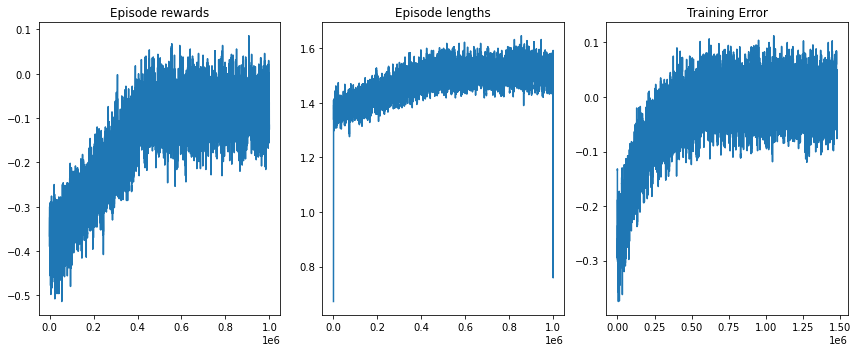

In [7]:
rolling_length = 500
fig, axs = plt.subplots(ncols=3, figsize=(12, 5))
axs[0].set_title("Episode rewards") #rewards over time, we see that negative feedbacks are often given
# compute and assign a rolling average of the data to provide a smoother graph
reward_moving_average = (
    np.convolve( # cumulative rewards of the recent n_episodes-many episodes
        np.array(env.return_queue).flatten(), np.ones(rolling_length), mode="valid"
    )
    / rolling_length #normalize
)
axs[0].plot(range(len(reward_moving_average)), reward_moving_average)
axs[1].set_title("Episode lengths")
length_moving_average = (
    np.convolve( # training lengths
        np.array(env.length_queue).flatten(), np.ones(rolling_length), mode="same"
    )
    / rolling_length
)
axs[1].plot(range(len(length_moving_average)), length_moving_average)
axs[2].set_title("Training Error")
training_error_moving_average = (
    np.convolve(np.array(agent.training_error), np.ones(rolling_length), mode="same")
    / rolling_length
)
axs[2].plot(range(len(training_error_moving_average)), training_error_moving_average)
plt.tight_layout()
plt.show() #training error (the temporal differnce)

<img src="file://_static/img/tutorials/blackjack_training_plots.png">




## Visualising the policy



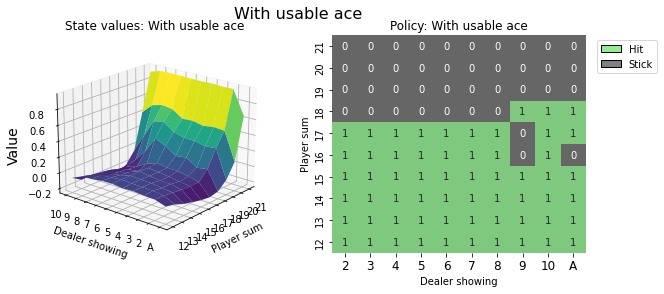

In [8]:
def create_grids(agent, usable_ace=False):
    """Create value and policy grid given an agent."""
    # convert our state-action values to state values
    # and build a policy dictionary that maps observations to actions
    state_value = defaultdict()
    policy = defaultdict()
    # record policy from the Q matrix
    for state, action_values in agent.q_values.items(): #q_value.items return the state-action pairs
        state_value[state] = float(np.max(action_values))
        policy[state] = int(np.argmax(action_values)) #the policy

    player_count, dealer_count = np.meshgrid(
        # players count, dealers face-up card
        np.arange(12, 22),
        np.arange(1, 11),
    )

    # create the value grid for plotting
    value = np.apply_along_axis(
        lambda state: state_value[(state[0], state[1], usable_ace)],
        axis=2,
        arr=np.dstack([player_count, dealer_count]),
    ) # take 1 (draw card) or not
    value_grid = player_count, dealer_count, value

    # create the policy grid for plotting
    policy_grid = np.apply_along_axis(
        lambda state: policy[(state[0], state[1], usable_ace)],
        axis=2,
        arr=np.dstack([player_count, dealer_count]),
    )
    return value_grid, policy_grid


def create_plots(value_grid, policy_grid, title: str):
    """Creates a plot using a value and policy grid."""
    # create a new figure with 2 subplots (left: state values, right: policy)
    player_count, dealer_count, value = value_grid
    fig = plt.figure(figsize=plt.figaspect(0.4))
    fig.suptitle(title, fontsize=16)

    # plot the state values
    ax1 = fig.add_subplot(1, 2, 1, projection="3d")
    ax1.plot_surface(
        player_count,
        dealer_count,
        value,
        rstride=1,
        cstride=1,
        cmap="viridis",
        edgecolor="none",
    )
    plt.xticks(range(12, 22), range(12, 22))
    plt.yticks(range(1, 11), ["A"] + list(range(2, 11)))
    ax1.set_title(f"State values: {title}")
    ax1.set_xlabel("Player sum")
    ax1.set_ylabel("Dealer showing")
    ax1.zaxis.set_rotate_label(False)
    ax1.set_zlabel("Value", fontsize=14, rotation=90)
    ax1.view_init(20, 220)

    # plot the policy
    fig.add_subplot(1, 2, 2)
    ax2 = sns.heatmap(policy_grid, linewidth=0, annot=True, cmap="Accent_r", cbar=False)
    ax2.set_title(f"Policy: {title}")
    # swapped x and y axis to fit with basic strategy
    ax2.set_ylabel("Player sum")
    ax2.set_xlabel("Dealer showing")
    ax2.set_yticklabels(range(12, 22))
    ax2.set_xticklabels(list(range(2, 11)) + ["A"], fontsize=12)
    ax2.invert_yaxis() # descending order, modified to fit with basic strategy visualization

    # add a legend
    legend_elements = [
        Patch(facecolor="lightgreen", edgecolor="black", label="Hit"),
        Patch(facecolor="grey", edgecolor="black", label="Stick"),
    ]
    ax2.legend(handles=legend_elements, bbox_to_anchor=(1.3, 1))
    return fig


# state values & policy with usable ace (ace counts as 11)
value_grid, policy_grid = create_grids(agent, usable_ace=True)
def process(policy_grid):
    """
    transform the policy grid to match the original
    basic policy strategy visualization
    written by Allen Tong"""
    policy_grid=policy_grid.transpose()
    permutation = [9, 0, 1, 2, 3, 4, 5, 6, 7, 8] # move columns to where they should be
    idx = np.empty_like(permutation) #make a np array of the indices
    idx[permutation] = np.arange(len(permutation))
    policy_grid[:] = policy_grid[:, idx] #replace old np array
    return policy_grid
# print(policy_grid)
# move column of ace (A) to the rightmost
policy_grid=process(policy_grid)
# print(policy_grid)
fig1 = create_plots(value_grid, policy_grid, title="With usable ace")
plt.show()

<img src="file://_static/img/tutorials/blackjack_with_usable_ace.png">




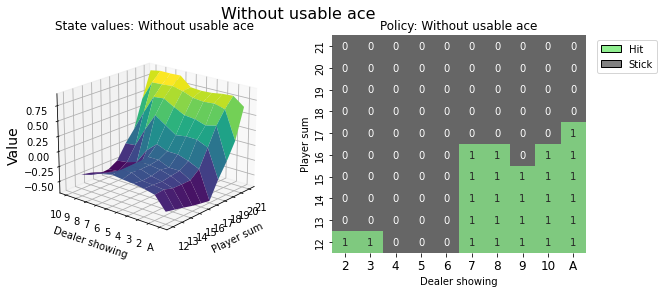

In [9]:
# state values & policy without usable ace (ace counts as 1)
value_grid, policy_grid = create_grids(agent, usable_ace=False)
policy_grid=process(policy_grid)
fig2 = create_plots(value_grid, policy_grid, title="Without usable ace")
plt.show()

In [10]:
env.close()

<img src="file://_static/img/tutorials/blackjack_without_usable_ace.png">

It's good practice to call env.close() at the end of your script,
so that any used resources by the environment will be closed.




## Think you can do better?



In [ ]:
# You can visualize the environment using the play function
# and try to win a few games.

Hopefully this Tutorial helped you get a grip of how to interact with
OpenAI-Gym environments and sets you on a journey to solve many more RL
challenges.

It is recommended that you solve this environment by yourself (project
based learning is really effective!). You can apply your favorite
discrete RL algorithm or give Monte Carlo ES a try (covered in [Sutton &
Barto](http://incompleteideas.net/book/the-book-2nd.html), section
5.3) - this way you can compare your results directly to the book.

Best of fun!


